# Agent Coder

In [ ]:
# | default_exp agent_coder

In [ ]:
# | export

from IPython.display import Image, display
from langgraph.graph import StateGraph, END, START, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder, PromptTemplate
from langchain_core.output_parsers.string import StrOutputParser
from pydantic import BaseModel, Field
from typing import List, Annotated, Literal
from operator import add, attrgetter
import textwrap
import os
from trustcall import create_extractor

## Prompts

In [ ]:
# | export

sample_input = {
    "code_snippet": 'from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n    """ Check if in given list of numbers, are any two numbers closer to each other than\n    given threshold.\n    >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n    False\n    >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n    True\n    """\n',
    "entry_point": "has_close_elements",
}

In [ ]:
# | export

coder_prompt = textwrap.dedent(
    """
    **Role**: You are a software programmer. 
    
    **Task**: As a programmer, you are required to complete the function. Use a Chain-of-Thought approach to break down the problem, create pseudocode, and then write the code in Python language. Ensure that your code is efficient, readable, and well-commented. For example: 
    
    **Input Code Snippet**: 
    ```python 
    {code_snippet}
    # TODO: Implement the logic to determine if any two numbers are closer than the threshold pass 

    # Add your code here to complete the function
    ```
    **Instructions**: 
    1. **Understand and Clarify**: Make sure you understand the task. 
    2. **Algorithm/Method Selection**: Decide on the most efficient way. 
    3. **Pseudocode Creation**: Write down the steps you will follow in pseudocode. 
    4. **Code Generation**: Translate your pseudocode into executable Python code.
    """
).strip()

response = textwrap.dedent(
    '''
    As a software developer, I'll follow the Chain-of-Thought approach outlined in the prompt to complete the `has_close_elements` function. Let's break it down into the four steps: 
    
    1. **Understand and Clarify**: 
    - The task is to write a function that checks if any two numbers in a given list are closer to each other than a specified threshold. 
    - The function should return `True` if such a pair exists, otherwise `False`. 
    
    2. **Algorithm/Method Selection**: 
    - A straightforward way to solve this would be to compare each number with every other number in the list. 
    - We can use a nested loop where each number is compared to every number that comes after it in the list. 
    - The absolute difference between each pair will be calculated and compared to the threshold. 
    
    3. **Pseudocode Creation**: 
    ```
    function has_close_elements(numbers, threshold): 
        loop through each number in the list (i) 
            for each number, loop through the remaining numbers in the list (j) 
                if the absolute difference between numbers[i] and numbers[j] is less than or equal to the threshold 
                    return True 
    if no such pair is found, return False 
    ``` 
    
    4. **Code Generation**: 
    - Now, I'll translate the pseudocode into Python code. Here's the complete function: 
    ```python 
    from typing import List 
    
    def has_close_elements(numbers: List[float], threshold: float) -> bool: 
        """ 
        Check if in given list of numbers, are any two numbers closer to each other than given threshold. 
        
        >>> has_close_elements([1.0, 2.0, 3.0], 0.5) 
        False 
        >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3) 
        True 
        """ 
        # Loop through each number in the list 
        for i in range(len(numbers)): 
            # For each number, loop through the remaining numbers 
            for j in range(i + 1, len(numbers)): 
                # If the absolute difference is less than or equal to the threshold, return True 
                if abs(numbers[i] - numbers[j]) <= threshold: 
                    return True 
                    
        # If no such pair is found, return False 
        return False 
        ```
'''
).strip()

structure_code = textwrap.dedent(
    '''
    Extract or update the items of the 'Coder' Pydantic class from the previous conversation:
                                    
    <convo>
    {conversation}
    </convo>"""
    '''
).strip()

In [ ]:
# | export

tester_prompt = textwrap.dedent(
    """
    **Role**: As a tester, your task is to create comprehensive test cases for the incomplete `{entry_point}` function. These test cases should encompass Basic, Edge, and Large Scale scenarios to ensure the code's robustness, reliability, and scalability. 
    
    **Input Code Snippet**: 
    ```python
    {code_snippet} 
    ```
    **1. Basic Test Cases**: 
    - **Objective**: To verify the fundamental functionality of the `{entry_point}` function under normal conditions. 
    
    **2. Edge Test Cases**: 
    - **Objective**: To evaluate the function's behavior under extreme or unusual conditions. 
    
    **3. Large Scale Test Cases**: 
    - **Objective**: To assess the function’s performance and scalability with large data samples. 
    
    **Instructions**: 
    - Implement a comprehensive set of test cases following the guidelines above. 
    - Ensure each test case is well-documented with comments explaining the scenario it covers. 
    - Pay special attention to edge cases as they often reveal hidden bugs. 
    - For large-scale tests, focus on the function's efficiency and performance under heavy loads.
    """
).strip()


tester_response = textwrap.dedent(
    """
    **Role**: As a tester, your task is to create and execute a series of test cases for the `{entry_point}` function. These test cases should include Basic, Edge, and Large Scale scenarios to ensure the function's robustness, reliability, and scalability.

    **Input Code Snippet**:
    ```python
    {code_snippet}
    ```

    **1. Basic Test Cases**:
    - **Objective**: Verify the fundamental functionality of the `{entry_point}` function under normal conditions.
    - **Examples**:
        ```python
        # Test 1: Standard case with close elements
        assert {entry_point}([1.0, 2.5, 3.5, 5.0], 1.0) == True
        
        # Test 2: Standard case with no close elements
        assert {entry_point}([1.0, 3.0, 5.0, 7.0], 1.5) == False
        ```

    **2. Edge Test Cases**:
    - **Objective**: Evaluate the function's behavior under extreme or unusual conditions.
    - **Examples**:
        ```python
        # Test 1: Empty list
        assert {entry_point}([], 1.0) == False
        
        # Test 2: List with all identical elements
        assert {entry_point}([3.0, 3.0, 3.0], 0.0) == True
        
        # Test 3: Very small threshold
        assert {entry_point}([1.0, 1.01, 2.0], 0.005) == False
        
        # Test 4: List with only two elements
        assert {entry_point}([1.0, 2.0], 1.5) == True
        ```

    **3. Large Scale Test Cases**:
    - **Objective**: Assess the function’s performance and scalability with large data samples.
    - **Examples**:
        ```python
        # Test 1: Large list with predictable pattern
        large_list = [i * 0.1 for i in range(100000)]  # Creates a list [0, 0.1, 0.2, ..., 9999.9]
        
        # Test with a threshold where no close elements exist
        assert {entry_point}(large_list, 0.05) == False
        
        # Test with a larger threshold where adjacent elements are within the threshold
        assert {entry_point}(large_list, 0.15) == True
        ```

    **Instructions**:
    - Implement and execute these test cases.
    - Document any errors, inefficiencies, or unexpected behaviors observed during testing.
    """
).strip()

structure_test = textwrap.dedent(
    '''
    Extract the items of the 'Tester' Pydantic class from the previous conversation:
                                    
    <convo>
    {conversation}
    </convo>"""
    '''
).strip()

## Templates

In [ ]:
# | export


class Coder(BaseModel):
    clarify: str = Field(description="Make sure you understand the task.")
    algo: str = Field(
        description="Decide on the most efficient implementation.")
    pseudocode: str = Field(
        description="Write down the steps you follow in the implementation in pseudocode."
    )
    code: str = Field(
        description="translate your pseudocode into executable Python code"
    )


class Tester(BaseModel):
    basic: List[str] = Field(
        description="Basic test cases, each of them in Python code"
    )
    edge: List[str] = Field(
        description="Edge case test cases, each of them in Python code"
    )
    large: List[str] = Field(
        description="Large scale test cases, testing for performance, each of the in Python code"
    )

## Runnables

In [ ]:
# | export

LLM = ChatOpenAI(
    model_name="gpt-4o",
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    temperature=0.0,
)

In [ ]:
# | export

coder_template = ChatPromptTemplate(
    messages=[
        ("user", coder_prompt.format(**sample_input)),
        ("ai", response),
        ("user", coder_prompt),
        MessagesPlaceholder("messages", optional=True),
    ],
    input_variables=["code_snippet", "messages"],
)

code = create_extractor(
    LLM, tools=[Coder], tool_choice="Coder", enable_inserts=True)

In [ ]:
# | export

tester_template = ChatPromptTemplate(
    messages=[
        ("user", tester_prompt.format(**sample_input)),
        ("ai", tester_response.format(**sample_input)),
        ("user", tester_prompt),
    ],
    input_variables=["code_snippet", "entry_point"],
)

tests = create_extractor(LLM, tools=[Tester], tool_choice="Tester")

## States

In [ ]:
# | export

class InputState(MessagesState):
    code_snippet: str
    entry_point: str


class OverallState(InputState):
    tester: Tester
    coder: Annotated[List[Coder], add]

## Nodes

In [ ]:
# | export

def write_program(state: OverallState) -> OverallState:
    return {"messages": (coder_template | LLM).invoke(**state)}


def get_code(state: OverallState) -> OverallState:
    if state["coder"]:
        structured = code.invoke(
            {
                "messages": [
                    (
                        "user",
                        structure_code.format(
                            conversation=state["messages"][-1].content
                        ),
                    )
                ],
                "existing": {"Coder": state["coder"][-1].model_dump()},
            }
        )
    else:
        structured = code.invoke(
            structure_code.format(conversation=state["messages"][-1].content)
        )
    return {"coder": structured["response"][0], "messages": structured["messages"]}


def write_tests(state: OverallState) -> OverallState:
    structured_tests = (tester_prompt | LLM | StrOutputParser | PromptTemplate.from_template(
        structure_test) | tests).invoke(**state)
    return {"tests": structured_tests["response"][0]}


def executor(state: OverallState) -> OverallState:
    error_messages = []
    for test_type in ["base", "edge", "large"]:
        for test in attrgetter(test_type)(state["tester"]):
            try:
                exec(state["coder"].code + test)
            except Exception as e:
                error_messages.append(
                    (
                        "user",
                        textwrap.dedent(
                            """
                            FAILED TEST

                            Your solution failed the test 
                                    
                            <test>               
                            {test}
                            <test>

                            with the error message:

                            <error>
                            {error}
                            <error>                
                            """
                        ).strip().format(test=test, error=e),
                    )
                )
    return {"messages": error_messages}

## Conditional Edges

In [ ]:
# | export

def correct_implementation(state: OverallState) -> Literal["Programmer", END]:
    if 'FAILED TEST' in state['messages'][-1].content:
        return "Programmer"
    else:
        return END

## Build Graph

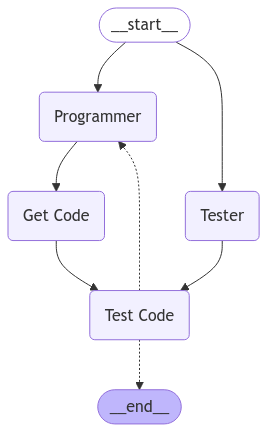

In [ ]:
# | export

workflow = StateGraph(OverallState, input=InputState)

# add nodes
workflow.add_node("Programmer", write_program)
workflow.add_node("Get Code", get_code)
workflow.add_node("Tester", write_tests)
workflow.add_node("Test Code", executor)

# add edges
workflow.add_edge(START, "Programmer")
workflow.add_edge(START, "Tester")
workflow.add_edge("Programmer", "Get Code")
workflow.add_edge("Get Code", "Test Code")
workflow.add_edge('Tester', "Test Code")
workflow.add_conditional_edges("Test Code", correct_implementation)

# compile the graph

memory = MemorySaver()
coder = workflow.compile(checkpointer=memory)

# View
display(Image(coder.get_graph(xray=1).draw_mermaid_png()))

In [ ]:
# | hide
from nbdev.showdoc import *

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()